In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
import h5py
import pyvisa
import time
from scipy.signal import savgol_filter
import scipy.signal as signal
from scipy import interpolate
from scipy.signal import windows
from matplotlib.ticker import MaxNLocator
from scipy.optimize import least_squares

In [2]:
factor = 2
SMALL_SIZE = factor*8
MEDIUM_SIZE = factor*10
BIGGER_SIZE = factor*12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Plotting functions

In [3]:
def plot(rn_arr, fname="test.hdf", comment="", I_ylim=None, do_I=True):
    # get data from file
    with h5py.File(fname, 'r') as f:
        # determine how many datasets are available
        i_max = 0
        for rn in rn_arr:
            try:
                f[rn]
                i_max += 1
            except KeyError:
                pass
        
        # combine the data from the available datasets
        dset = np.concatenate([np.array(f[rn]) for rn in rn_arr[:i_max]])
        
    t = dset[:,0] - dset[0,0]

    # choose time unit
    if t[-1] > 24*3600:
        t_unit = "days"
        div = 24*3600
    elif t[-1] > 3600:
        t_unit = "h"
        div = 3600
    elif t[-1] > 60:
        t_unit = "min"
        div = 60
    else:
        t_unit = "s"
        div = 1

    # plot the data
    fig, axx = plt.subplots(nrows=2 if do_I else 1, figsize=(8,6 if do_I else 4), squeeze=False)
    axx[0,0].plot(t/div, 3*dset[:, 1], label="voltage_monitor")
    axx[0,0].plot(t/div, 3*dset[:, 3], label="voltage_program")
    axx[0,0].plot(t/div, 10*dset[:, 4], label="divider_voltage")
    if do_I:
        axx[1,0].plot(t/div, 40*dset[:, 2], label="current_monitor")
#     ax.plot(t/div, dset[:, 5], label="error_voltage")
    
    # plot format
    axx[-1,0].set_xlabel(f"time [{t_unit}]")
    axx[0,0].set_ylabel("voltage [kV]")
    axx[0,0].set_title(f"{comment}")
    if do_I:
        axx[1,0].set_ylabel("current [$\\mu$A]")
        axx[1,0].set_ylim(I_ylim)
    for ax in axx:
        ax[0].legend(loc=(1.05,.2))
        ax[0].grid()
    plt.tight_layout()

In [4]:
def leakage_plot(rn_arr, fname="test.hdf", comment="", I_ylim=None, text_loc=[0.95, 0.85], discard_fraction=2,
                 win_fn=windows.boxcar, win_len=51, fit_exp=False, figsize=(5,3), leg_loc=(1.05,.2), do_win=True,
                 do_text=True, linear=True):
    # get data from file
    with h5py.File(fname, 'r') as f:
        # determine how many datasets are available
        i_max = 0
        for rn in rn_arr:
            try:
                f[rn]
                i_max += 1
            except KeyError:
                pass
        
        # combine the data from the available datasets
        dset = np.concatenate([np.array(f[rn]) for rn in rn_arr[:i_max]])
        
    t = dset[:,0] - dset[0,0]

    # choose time unit
    if t[-1] > 24*3600:
        t_unit = "days"
        div = 24*3600
    elif t[-1] > 3600:
        t_unit = "h"
        div = 3600
    elif t[-1] > 60:
        t_unit = "min"
        div = 60
    else:
        t_unit = "s"
        div = 1

    # plot the data
    fig, ax = plt.subplots(nrows=1, figsize=figsize)
    I_leak = 1e9*dset[:, 6]
    ax.plot(t/div, I_leak, label="leakage current")
    if do_win:
        I_leak_win = np.convolve(I_leak, win_fn(win_len)/np.sum(win_fn(win_len)), mode="valid")
        ax.plot(t[win_len//2:-win_len//2+1]/div, I_leak_win, label=f"{win_fn.__name__}({win_len})")
    
    # exponential fit
    if fit_exp:
        if linear:
            fit_fn = lambda t, A, t0, C, D : A*np.exp(-t/t0) + C - t/D
            popt = [4, 3, 1, 10]
        else:
            fit_fn = lambda t, A, t0, C : A*np.exp(-t/t0) + C
            popt = [1, .5, 1]
        if do_win:
            popt, pcov = curve_fit(fit_fn, t[win_len//2:-win_len//2+1]/div, I_leak_win, p0=popt)
        else:
            popt, pcov = curve_fit(fit_fn, t/div, I_leak, p0=popt)
        if linear:
            ax.plot(t/div, fit_fn(t/div, *popt), color="black", label=f"${popt[0]:.2f}e^{{-t/{popt[1]:.2f}}} - \\frac{{t}}{{{popt[3]:.1f}}} + {popt[2]:.2f}$")
        else:
            ax.plot(t/div, fit_fn(t/div, *popt), color="black", label=f"${popt[0]:.2f}e^{{-t/{popt[1]:.2f}}} + {popt[2]:.2f}$")

    # indicate average current
    I_avg = np.average(I_leak[len(I_leak)//discard_fraction:])
    I_std = np.std(I_leak[len(I_leak)//discard_fraction:])
    if do_text:
        ax.text(*text_loc, f'({I_avg:.2f} ± {I_std:.2f}) nA',
            horizontalalignment='right',
            verticalalignment='center',
            transform = ax.transAxes)
    
    # find average voltage
    V_monitor = 3*dset[:, 1]
    V_avg = np.average(V_monitor[len(V_monitor)//discard_fraction:])
    
    # plot format
    ax.set_xlabel(f"time [{t_unit}]")
    ax.set_ylabel("current [nA]")
    ax.set_title(f"leakage current @ {V_avg:.1f} kV")
    ax.set_ylim(I_ylim)
    ax.legend(loc=leg_loc)
    ax.grid()

In [5]:
def voltage_plot(rn_arr, fname="test.hdf", figsize=(5,3), comment="", V0=0, ylim=None,
                 win_fn=None, win_len=25, leg_loc=None, rel_unit="ppm"):
    # get data from file
    with h5py.File(fname, 'r') as f:
        # determine how many datasets are available
        i_max = 0
        for rn in rn_arr:
            try:
                f[rn]
                i_max += 1
            except KeyError:
                pass
        
        # combine the data from the available datasets
        dset = np.concatenate([np.array(f[rn]) for rn in rn_arr[:i_max]])
        
    t = dset[:,0] - dset[0,0]

    # choose time unit
    if t[-1] > 24*3600:
        t_unit = "days"
        div = 24*3600
    elif t[-1] > 3600:
        t_unit = "h"
        div = 3600
    elif t[-1] > 60:
        t_unit = "min"
        div = 60
    else:
        t_unit = "s"
        div = 1

    # plot absolute or relative voltage
    fig, ax = plt.subplots(nrows=1, figsize=figsize)
    if V0:
        if V0 == "avg":
            V0 = round(np.average(dset[:,6]), 6)
        if rel_unit == "ppm":
            volts_ppm = 1e6*((dset[:, 6] - V0) / V0)
        elif rel_unit == "%":
            volts_ppm = 1e2*((dset[:, 6] - V0) / V0)
        ax.plot(t/div, volts_ppm, label="data")
        ax.set_ylabel(f"voltage error [{rel_unit}]")
        ax.set_title(f"$V_0=\,$${V0:.6f}$ V{comment}")
        
        if win_fn:
            volts_ppm_win = np.convolve(volts_ppm, win_fn(win_len)/np.sum(win_fn(win_len)), mode="valid")
            ax.plot(t[win_len//2:-win_len//2+1]/div, volts_ppm_win, label=f"{win_fn.__name__}({win_len})")
            ax.legend(loc=leg_loc)
    else:
        volts = dset[:, 6]
        ax.plot(t/div, volts, label="data")
        ax.set_ylabel("voltage [V]")
        ax.set_title(f"{comment}")
    
    # plot format
    ax.set_xlabel(f"time [{t_unit}]")
    ax.set_ylim(ylim)
    ax.grid()

In [6]:
def divider_plot(rn_arr, fname="test.hdf", win_fn=windows.boxcar, win_len=51, comment="", leg_loc=(1.05,.2), figsize=(5,3)):
    # get data from file
    with h5py.File(fname, 'r') as f:
        # determine how many datasets are available
        i_max = 0
        for rn in rn_arr:
            try:
                f[rn]
                i_max += 1
            except KeyError:
                pass
        
        # combine the data from the available datasets
        dset = np.concatenate([np.array(f[rn]) for rn in rn_arr[:i_max]])
        
    t = dset[:,0] - dset[0,0]

    # choose time unit
    if t[-1] > 24*3600:
        t_unit = "days"
        div = 24*3600
    elif t[-1] > 3600:
        t_unit = "h"
        div = 3600
    elif t[-1] > 60:
        t_unit = "min"
        div = 60
    else:
        t_unit = "s"
        div = 1

    # plot the data
    Vdiv = 10*dset[:, 4]
    fig, ax = plt.subplots(nrows=1, figsize=figsize)
    ax.plot(t/div, Vdiv, label="divider_voltage")
    
    # windowing function
    Vdiv_win = np.convolve(Vdiv, win_fn(win_len)/np.sum(win_fn(win_len)), mode="valid")
    ax.plot(t[win_len//2:-win_len//2+1]/div, Vdiv_win, label=f"{win_fn.__name__}({win_len})")
    
    # plot format
    ax.set_xlabel(f"time [{t_unit}]")
    ax.set_ylabel("voltage [kV]")
    ax.set_title(f"{comment}")
    ax.legend(loc=leg_loc)
    ax.grid()
    plt.tight_layout()

In [7]:
def plot_spectra(rn_arr_arr, lab_arr, V0_arr, fname="test.hdf", ylim=None,
                 hline=None, vline=None, leg_loc=None,
                 win_fn=None, win_len=1,
                 figsize=(5,3)):
    fig, ax = plt.subplots(figsize=figsize)
    
    for rn_arr, lab, V0 in zip(rn_arr_arr, lab_arr, V0_arr):
        # get data from file
        with h5py.File(fname, 'r') as f:
            # determine how many datasets are available
            i_max = 0
            for rn in rn_arr:
                try:
                    f[rn]
                    i_max += 1
                except KeyError:
                    pass

            # combine the data from the available datasets
            dset = np.concatenate([np.array(f[rn]) for rn in rn_arr[:i_max]])

        t = dset[:,0] - dset[0,0]
        if not V0:
            V0 = round(np.average(dset[:,6]), 6)
        ratio_ppm = (dset[:,6] - V0) / V0 * 1e6

        # plot the spectrum
        f_arr = np.fft.rfftfreq(len(t), np.average(np.diff(t)))
        NSD = lambda x : np.sqrt(2 * np.abs(np.fft.rfft(x))**2 / (len(x) / np.average(np.diff(t)))) # [Heinzel, Gerhard, Albrecht Rüdiger, and Roland Schilling. "Spectrum and spectral density estimation by the Discrete Fourier transform (DFT), including a comprehensive list of window functions and some new at-top windows." (2002). https://holometer.fnal.gov/GH_FFT.pdf]
        if win_fn:
            NSD_win = np.convolve(NSD(ratio_ppm), win_fn(win_len)/np.sum(win_fn(win_len)), mode="valid")
            ax.loglog(f_arr[win_len//2:-win_len//2+1], NSD_win, label=f"{lab} (${V0:.6f}$ V)")
        else:
            ax.loglog(f_arr[1:], NSD(ratio_ppm)[1:], label=f"{lab} (${V0:.5f}$ V)")

    # line markers
    if hline:
        ax.axhline(y=hline, ls="--", color="gray")
    if vline:
        ax.axvline(x=vline, ls="--", color="gray")
    
    # plot format
    ax.set_ylabel("NSD [ppm/$\sqrt{\mathrm{Hz}}$]")
    ax.set_ylim(ylim)
    if win_fn:
        ax.set_title(f"{win_fn.__name__}({win_len})")
    ax.legend(loc=leg_loc)
    ax.set_xlabel("frequency [Hz]")
    ax.grid()

### Testing

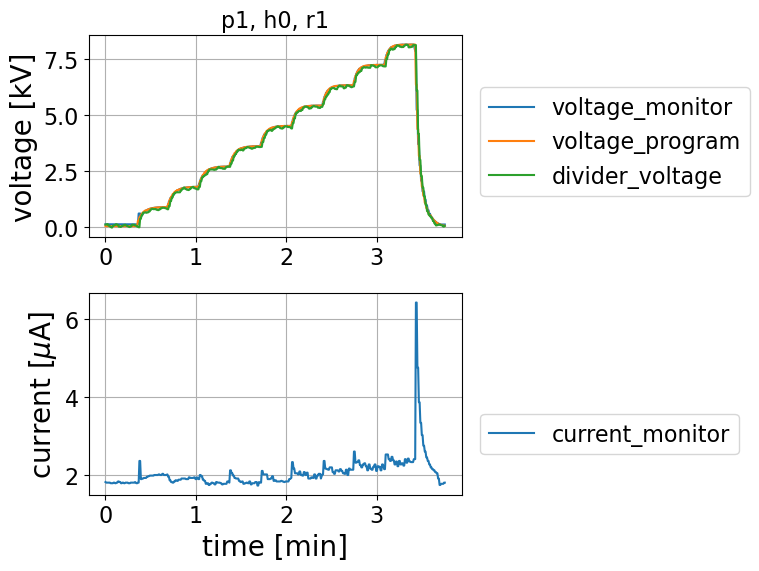

In [51]:
plot(
    rn_arr  = [f"A-{i}" for i in range(11)],
    fname   = "HV_leakage_test.hdf",
    comment = "p1, h0, r1",
    I_ylim  = None,
)

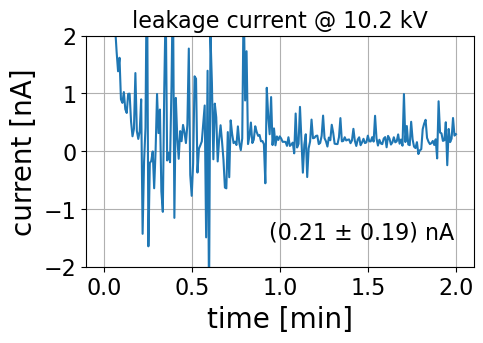

In [77]:
I_leak = leakage_plot(
    rn_arr  = [f"B-{i}" for i in range(1,2)],
    fname   = "HV_leakage_test.hdf",
    comment = "p1, h0, r1",
    I_ylim  = [-2, 2],
    text_loc = [0.95, 0.15],
)

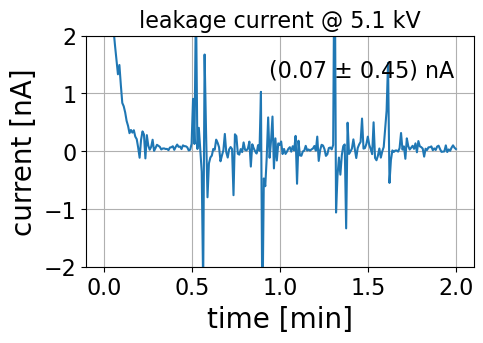

In [78]:
I_leak = leakage_plot(
    rn_arr  = ["B-2"],
    fname   = "HV_leakage_test.hdf",
    comment = "p1, h0, r1",
    I_ylim  = [-2, 2],
)

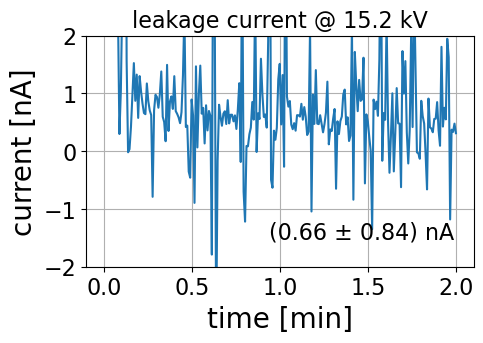

In [79]:
I_leak = leakage_plot(
    rn_arr   = ["B-3"],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-2, 2],
    text_loc = [0.95, 0.15],
)

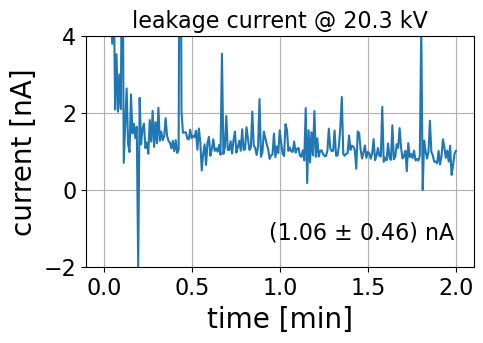

In [81]:
I_leak = leakage_plot(
    rn_arr   = ["B-4"],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-2, 4],
    text_loc = [0.95, 0.15],
)

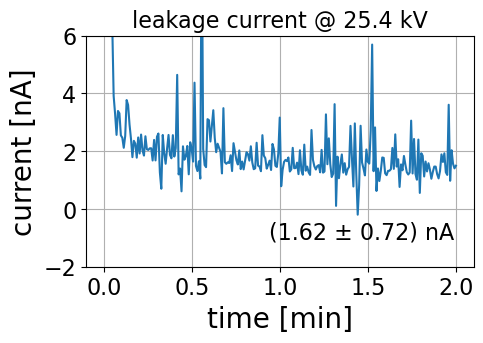

In [96]:
I_leak = leakage_plot(
    rn_arr   = ["B-5"],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-2, 6],
    text_loc = [0.95, 0.15],
)

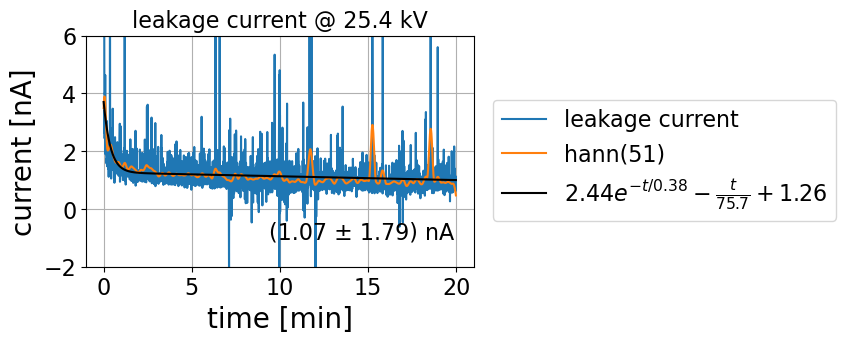

In [157]:
I_leak = leakage_plot(
    rn_arr   = ["B-6"],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-2, 6],
    text_loc = [0.95, 0.15],
    discard_fraction = 2,
    win_fn  = windows.hann,
    win_len = 51,
    fit_exp = True,
)

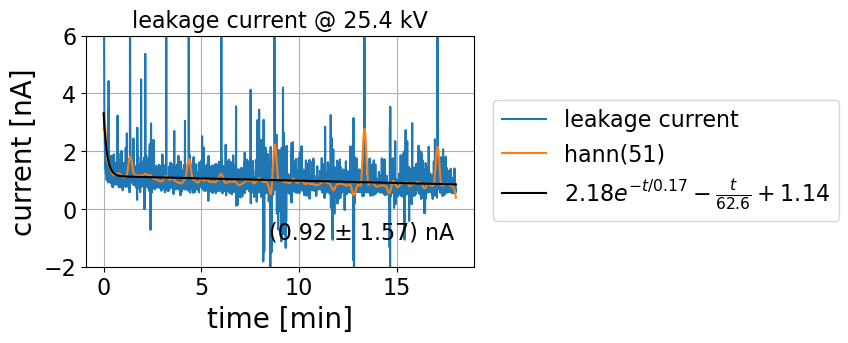

In [160]:
I_leak = leakage_plot(
    rn_arr   = [f"B-{7+i}" for i in range(3)],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-2, 6],
    text_loc = [0.95, 0.15],
    discard_fraction = 2,
    win_fn  = windows.hann,
    win_len = 51,
    fit_exp = True,
)

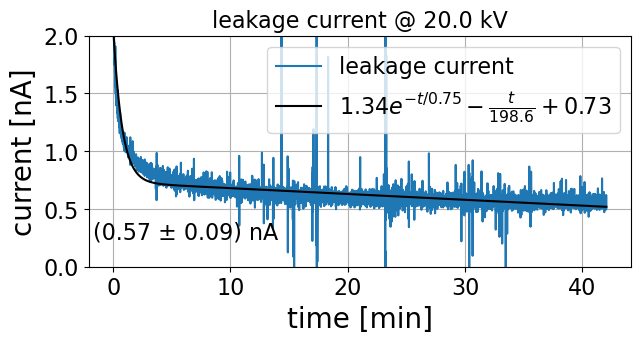

In [195]:
I_leak = leakage_plot(
    rn_arr   = [f"C-{i}" for i in range(7)],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-0, 2],
    text_loc = [0.35, 0.15],
    discard_fraction = 2,
    win_fn  = windows.hann,
    win_len = 51,
    fit_exp = True,
    figsize = (7,3),
    leg_loc = "upper right",
    do_win  = False,
)

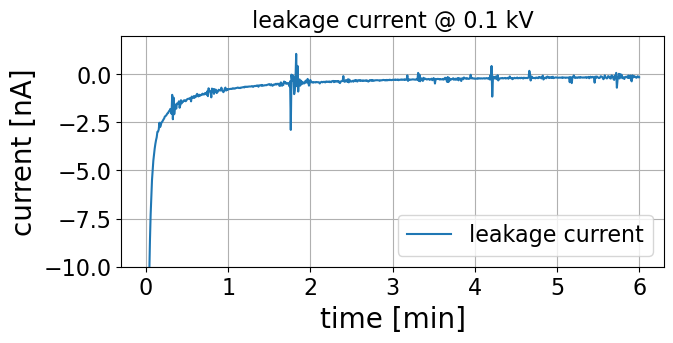

In [205]:
leakage_plot(
    rn_arr   = [f"D-{i}" for i in range(1)],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-10, 2],
    text_loc = [0.45, 0.85],
    discard_fraction = 2,
    win_fn  = windows.hann,
    win_len = 51,
    fit_exp = False,
    figsize = (7,3),
    leg_loc = None,
    do_win  = False,
    do_text = False,
)

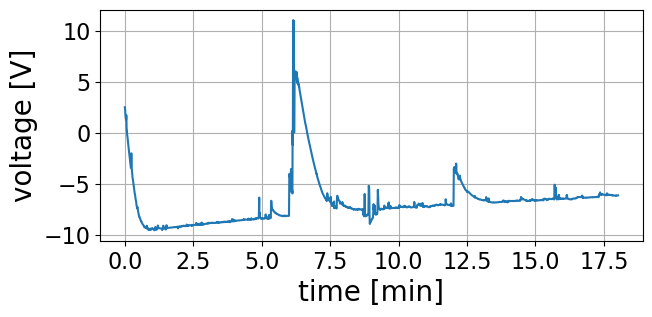

In [211]:
voltage_plot(
    rn_arr   = [f"E-{i}" for i in range(3)],
    fname    = "HV_leakage_test.hdf",
    figsize = (7,3),
)

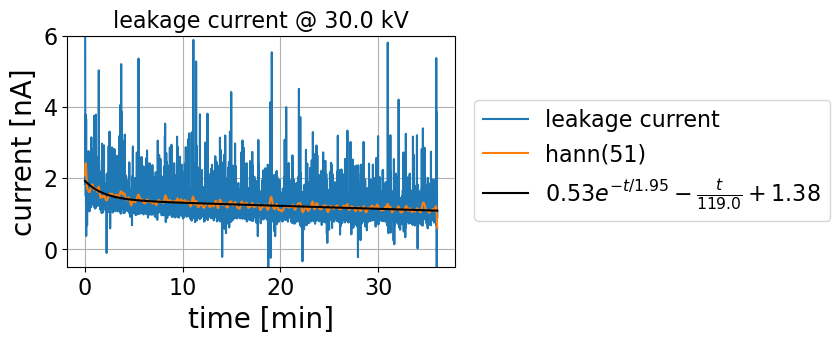

In [225]:
leakage_plot(
    rn_arr   = [f"F-{i}" for i in range(6)],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-.5, 6],
    text_loc = [0.45, 0.85],
    discard_fraction = 2,
    win_fn  = windows.hann,
    win_len = 51,
    fit_exp = True,
    figsize = (5,3),
    leg_loc = (1.05, .2),
    do_win  = True,
    do_text = False,
)

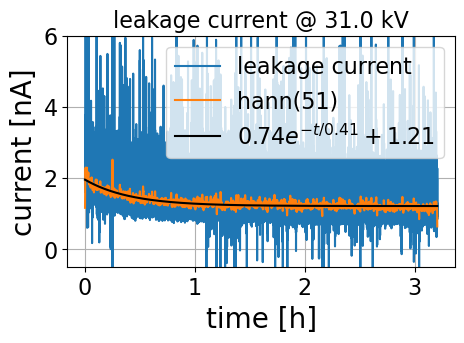

In [85]:
leakage_plot(
    rn_arr   = [f"G-{i}" for i in range(999)],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-.5, 6],
    text_loc = [0.45, 0.85],
    discard_fraction = 2,
    win_fn  = windows.hann,
    win_len = 51,
    fit_exp = True,
    figsize = (5,3),
    leg_loc = "upper right",
    do_win  = True,
    do_text = False,
    linear  = False
)

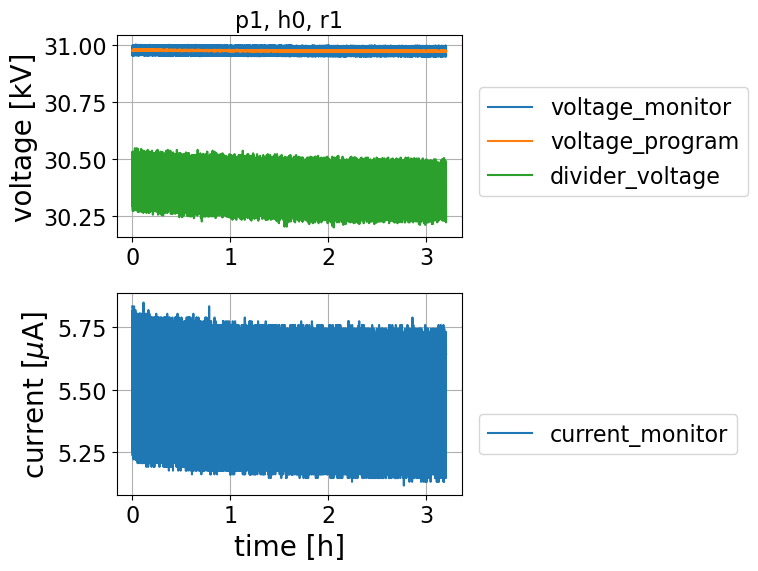

In [87]:
plot(
    rn_arr  = [f"G-{i}" for i in range(999)],
    fname   = "HV_leakage_test.hdf",
    comment = "p1, h0, r1",
    I_ylim  = None,
)

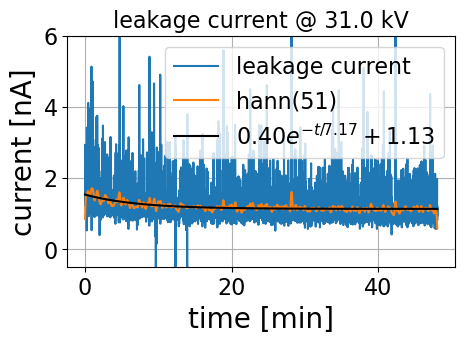

In [74]:
leakage_plot(
    rn_arr   = [f"H-{i}" for i in range(999)],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-.5, 6],
    text_loc = [0.45, 0.85],
    discard_fraction = 2,
    win_fn  = windows.hann,
    win_len = 51,
    fit_exp = True,
    figsize = (5,3),
    leg_loc = "upper right",
    do_win  = True,
    do_text = False,
    linear  = False
)

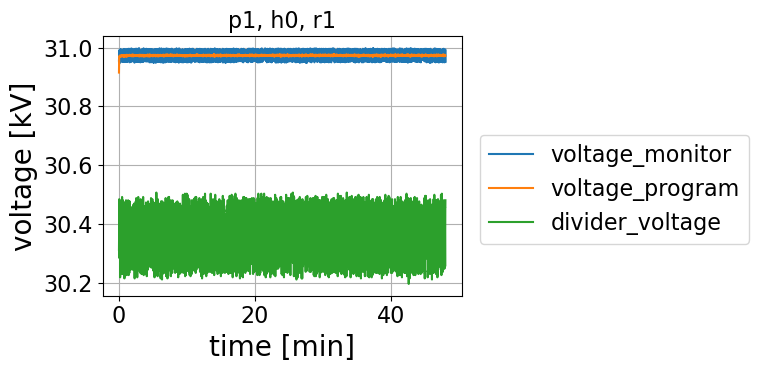

In [76]:
plot(
    rn_arr  = [f"H-{i}" for i in range(999)],
    fname   = "HV_leakage_test.hdf",
    comment = "p1, h0, r1",
    I_ylim  = None,
    do_I    = False,
)

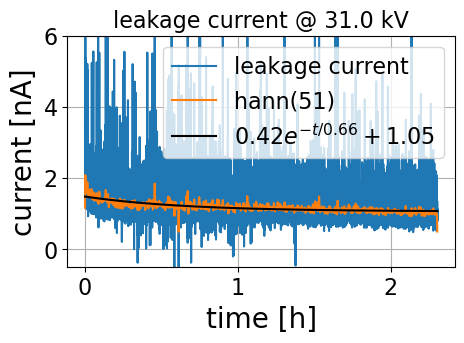

In [151]:
leakage_plot(
    rn_arr   = [f"I-{i}" for i in range(999)],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-.5, 6],
    text_loc = [0.45, 0.85],
    discard_fraction = 2,
    win_fn  = windows.hann,
    win_len = 51,
    fit_exp = True,
    figsize = (5,3),
    leg_loc = "upper right",
    do_win  = True,
    do_text = False,
    linear  = False
)

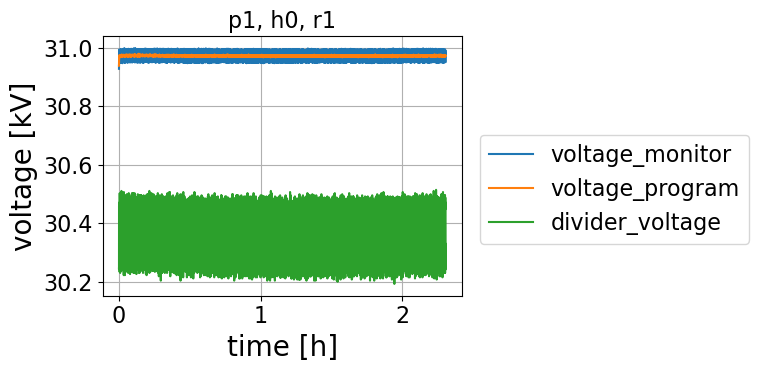

In [152]:
plot(
    rn_arr  = [f"I-{i}" for i in range(999)],
    fname   = "HV_leakage_test.hdf",
    comment = "p1, h0, r1",
    I_ylim  = None,
    do_I    = False,
)

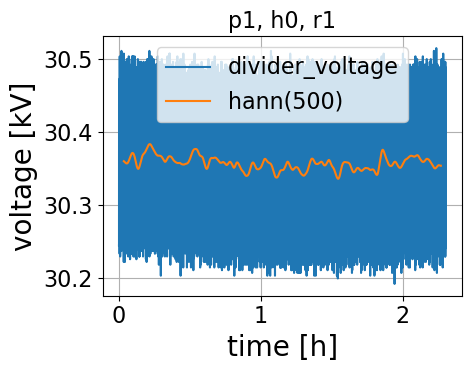

In [153]:
divider_plot(
    rn_arr  = [f"I-{i}" for i in range(999)],
    fname   = "HV_leakage_test.hdf",
    comment = "p1, h0, r1",
    win_fn  = windows.hann,
    win_len = 500,
    leg_loc = "upper center",
    figsize = (5,4),
)

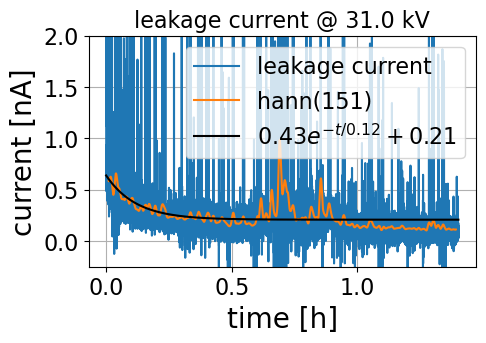

In [42]:
leakage_plot(
    rn_arr   = [f"J-{i}" for i in range(999)],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-.25, 2],
    text_loc = [0.45, 0.85],
    discard_fraction = 2,
    win_fn  = windows.hann,
    win_len = 151,
    fit_exp = True,
    figsize = (5,3),
    leg_loc = "upper right",
    do_win  = True,
    do_text = False,
    linear  = False
)

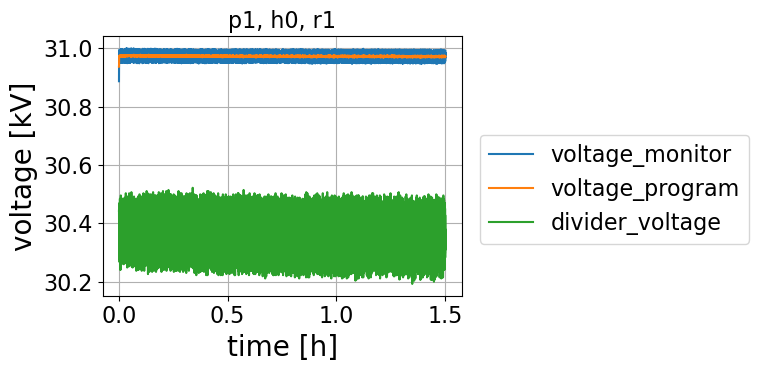

In [44]:
plot(
    rn_arr  = [f"J-{i}" for i in range(999)],
    fname   = "HV_leakage_test.hdf",
    comment = "p1, h0, r1",
    I_ylim  = None,
    do_I    = False,
)

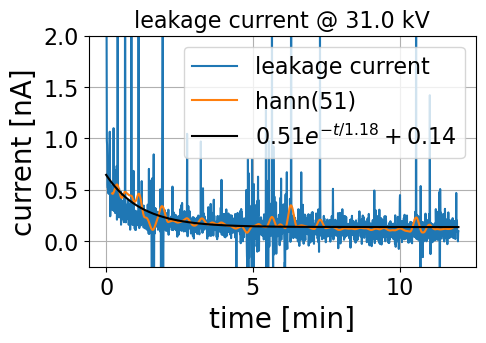

In [54]:
leakage_plot(
    rn_arr   = [f"K-{i}" for i in range(999)],
    fname    = "HV_leakage_test.hdf",
    comment  = "p1, h0, r1",
    I_ylim   = [-.25, 2],
    text_loc = [0.45, 0.85],
    discard_fraction = 2,
    win_fn  = windows.hann,
    win_len = 51,
    fit_exp = True,
    figsize = (5,3),
    leg_loc = "upper right",
    do_win  = True,
    do_text = False,
    linear  = False
)

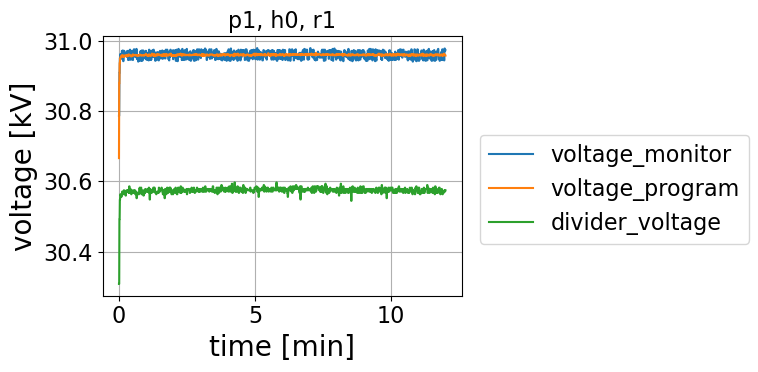

In [58]:
plot(
    rn_arr  = [f"K-{i}" for i in range(999)],
    fname   = "HV_leakage_test.hdf",
    comment = "p1, h0, r1",
    I_ylim  = None,
    do_I    = False,
)

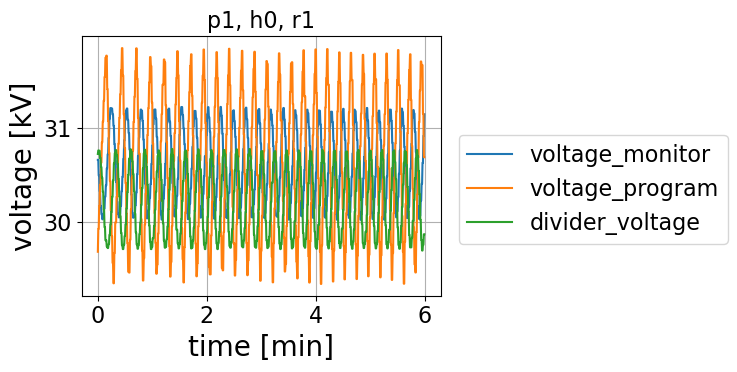

In [61]:
plot(
    rn_arr  = [f"L-{i}" for i in range(999)],
    fname   = "HV_leakage_test.hdf",
    comment = "p1, h0, r1",
    I_ylim  = None,
    do_I    = False,
)

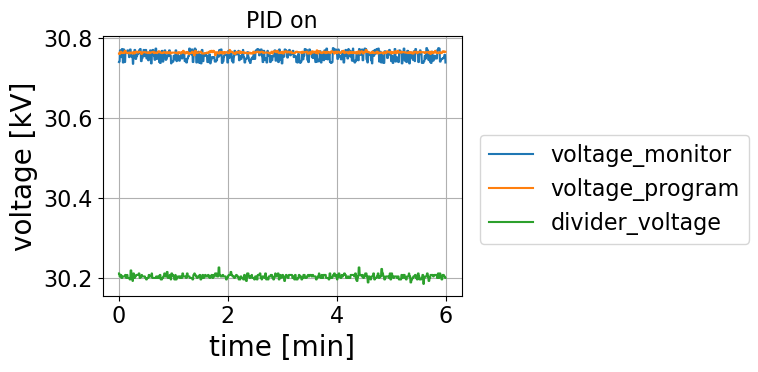

In [91]:
plot(
    rn_arr  = [f"M-{i}" for i in range(999)],
    fname   = "HV_leakage_test.hdf",
    comment = "PID on",
    I_ylim  = None,
    do_I    = False,
)

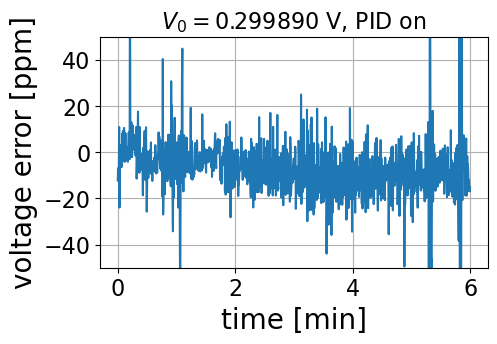

In [506]:
voltage_plot(
    rn_arr   = [f"M-{i}" for i in range(999)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID on",
    V0      = 0.29989,
    ylim    = [-50, 50],
)

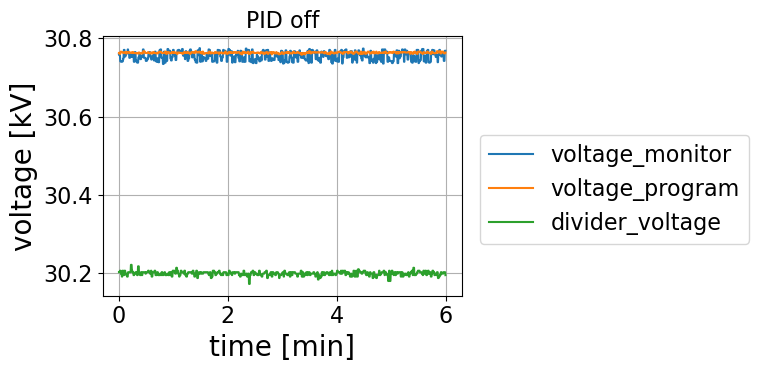

In [112]:
plot(
    rn_arr  = [f"N-{i}" for i in range(999)],
    fname   = "HV_leakage_test.hdf",
    comment = "PID off",
    I_ylim  = None,
    do_I    = False,
)

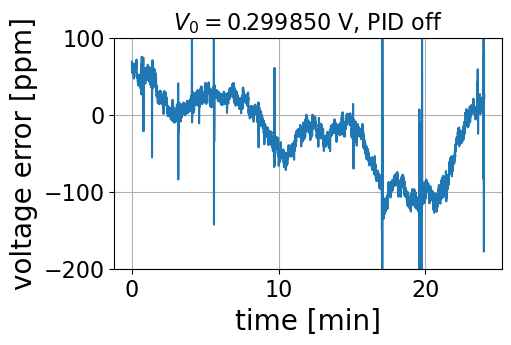

In [505]:
voltage_plot(
    rn_arr   = [f"N-{i}" for i in range(999)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID off",
    V0      = 0.29985,
    ylim    = [-200, 100],
)

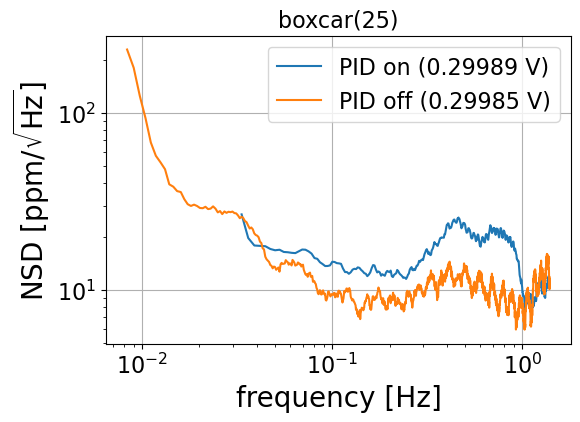

In [182]:
plot_spectra(
    rn_arr_arr = [
                    [f"M-{i}" for i in range(999)],
                    [f"N-{i}" for i in range(999)],
                 ],
    fname    = "HV_leakage_test.hdf",
    lab_arr    = ["PID on", "PID off"],
    V0_arr     = [0.29989, 0.29985],
    figsize = (6,4),
    win_fn  = windows.boxcar,
    win_len = 25,
#     ylim       = (1e-2, 1e3),
#     hline      = 0.05,
#     vline      = 1e-2,
)

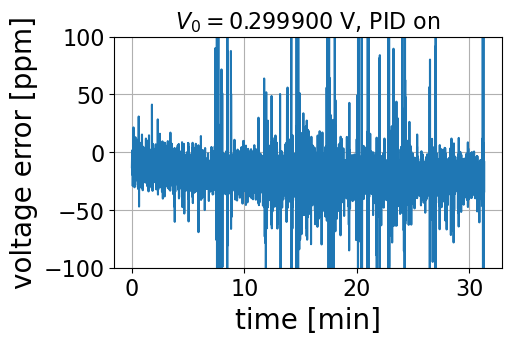

In [504]:
voltage_plot(
    rn_arr   = [f"O-{i}" for i in range(999)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID on",
    V0      = 0.2999,
    ylim    = [-100, 100],
)

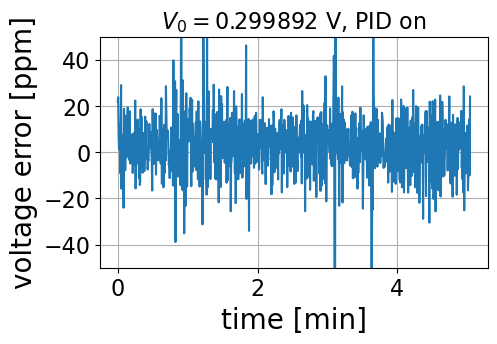

In [503]:
voltage_plot(
    rn_arr   = [f"P-{i}" for i in range(5)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID on",
    V0      = 0.299892,
    ylim    = [-50, 50],
)

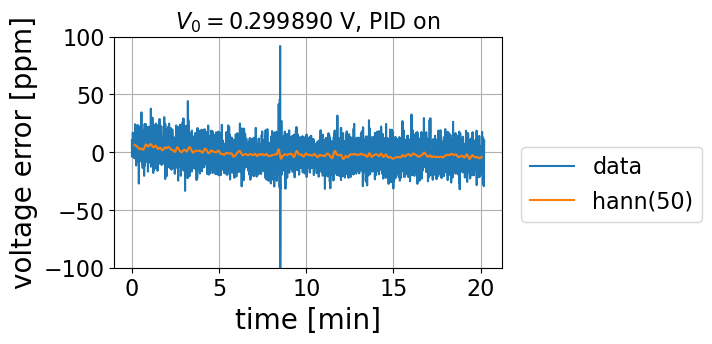

In [502]:
voltage_plot(
    rn_arr   = [f"Q-{i}" for i in range(20)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID on",
    V0      = "avg",
    ylim    = [-100, 100],
    win_fn  = windows.hann,
    win_len = 50,
    leg_loc = (1.05, .2),
)

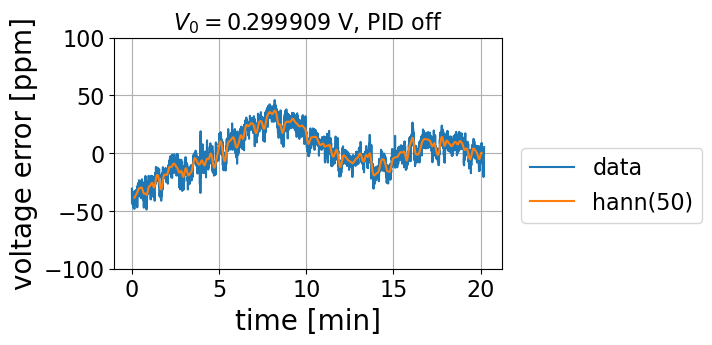

In [501]:
voltage_plot(
    rn_arr   = [f"R-{i}" for i in range(9999)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID off",
    V0      = "avg",
    ylim    = [-100, 100],
    win_fn  = windows.hann,
    win_len = 50,
    leg_loc = (1.05, .2),
)

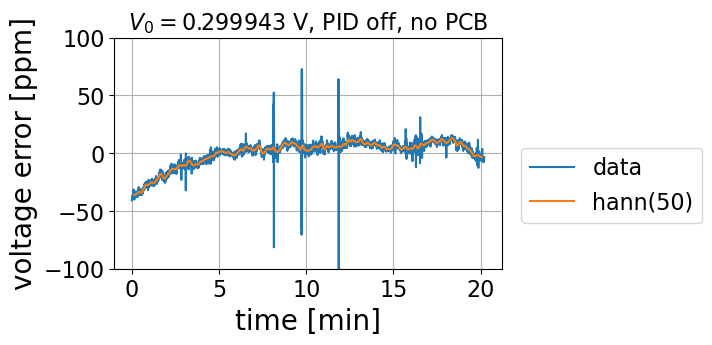

In [500]:
voltage_plot(
    rn_arr   = [f"S-{i}" for i in range(9999)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID off, no PCB",
    V0      = "avg",
    ylim    = [-100, 100],
    win_fn  = windows.hann,
    win_len = 50,
    leg_loc = (1.05, .2),
)

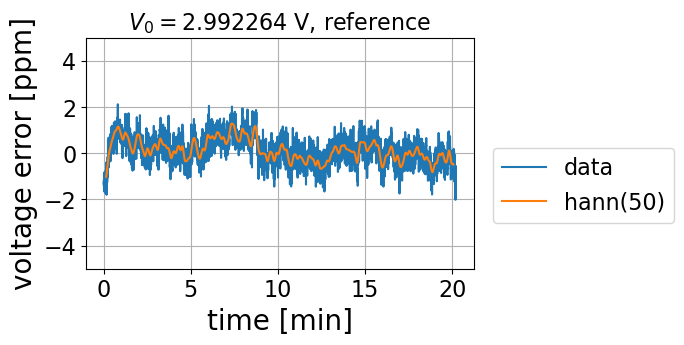

In [499]:
voltage_plot(
    rn_arr   = [f"T-{i}" for i in range(9999)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", reference",
    V0      = "avg",
    ylim    = [-5, 5],
    win_fn  = windows.hann,
    win_len = 50,
    leg_loc = (1.05, .2),
)

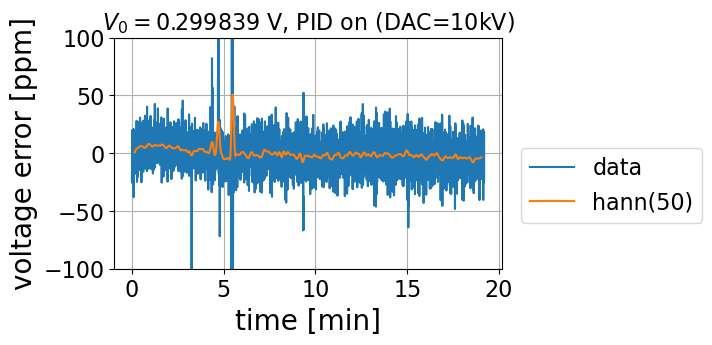

In [498]:
voltage_plot(
    rn_arr   = [f"U-{i}" for i in range(19)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID on (DAC=10kV)",
    V0      = "avg",
    ylim    = [-100, 100],
    win_fn  = windows.hann,
    win_len = 50,
    leg_loc = (1.05, .2),
)

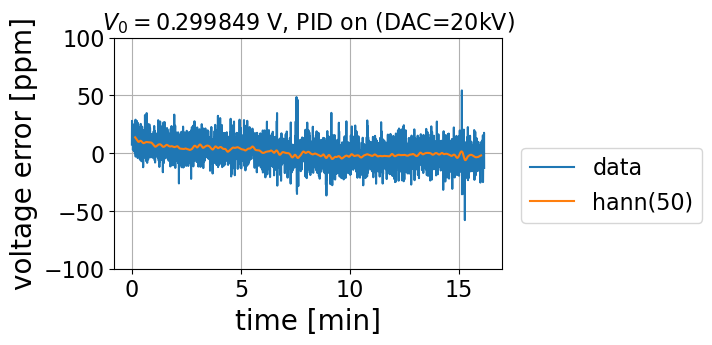

In [497]:
voltage_plot(
    rn_arr   = [f"V-{i}" for i in range(16)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID on (DAC=20kV)",
    V0      = "avg",
    ylim    = [-100, 100],
    win_fn  = windows.hann,
    win_len = 50,
    leg_loc = (1.05, .2),
)

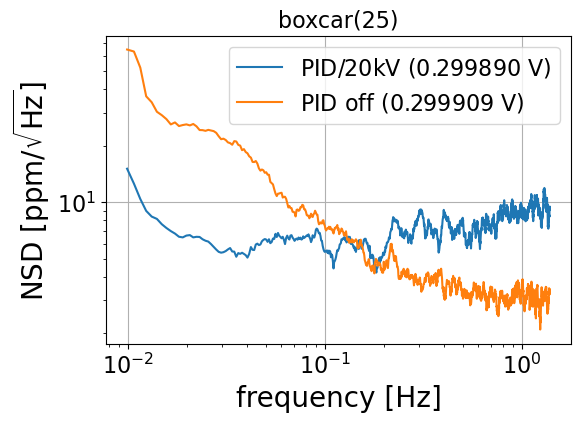

In [554]:
plot_spectra(
    rn_arr_arr = [
                    [f"Q-{i}" for i in range(20)],
                    [f"R-{i}" for i in range(9999)],
                 ],
    fname    = "HV_leakage_test.hdf",
    lab_arr    = ["PID/20kV", "PID off", "ref", "PID/10kV", "PID/20kV", "PID/20kV"],
    V0_arr     = [None, None, None, None, None, None],
    figsize = (6,4),
    win_fn  = windows.boxcar,
    win_len = 25,
    leg_loc = "upper right",
#     ylim       = (1e-2, 1e3),
#     hline      = 0.05,
#     vline      = 1e-2,
)

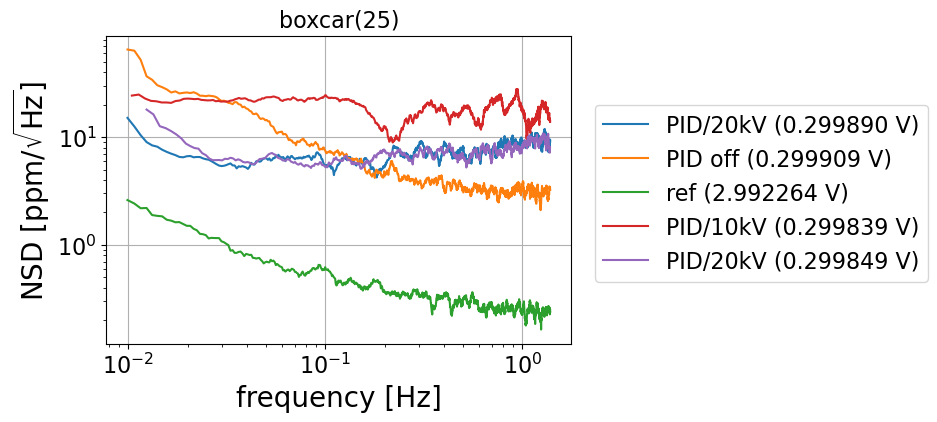

In [487]:
plot_spectra(
    rn_arr_arr = [
                    [f"Q-{i}" for i in range(20)],
                    [f"R-{i}" for i in range(9999)],
                    [f"T-{i}" for i in range(9999)],
                    [f"U-{i}" for i in range(19)],
                    [f"V-{i}" for i in range(16)],        
                 ],
    fname    = "HV_leakage_test.hdf",
    lab_arr    = ["PID/20kV", "PID off", "ref", "PID/10kV", "PID/20kV", "PID/20kV"],
    V0_arr     = [None, None, None, None, None, None],
    figsize = (6,4),
    win_fn  = windows.boxcar,
    win_len = 25,
    leg_loc = (1.05, .2)
#     ylim       = (1e-2, 1e3),
#     hline      = 0.05,
#     vline      = 1e-2,
)

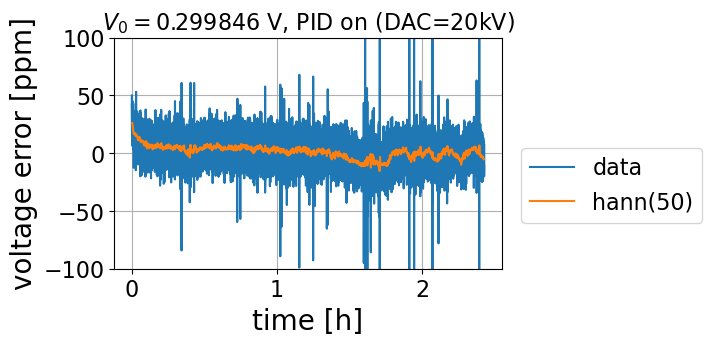

In [496]:
voltage_plot(
    rn_arr   = [f"W-{i}" for i in range(9999)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID on (DAC=20kV)",
    V0      = "avg",
    ylim    = [-100, 100],
    win_fn  = windows.hann,
    win_len = 50,
    leg_loc = (1.05, .2),
)

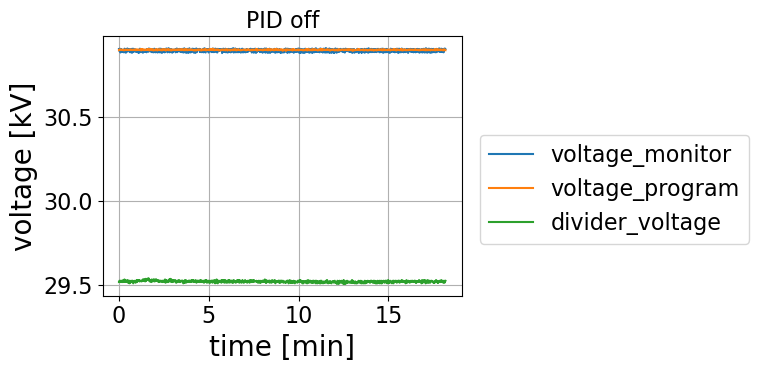

In [519]:
plot(
    rn_arr  = [f"X-{i}" for i in range(9999)],
    fname   = "HV_leakage_test.hdf",
    comment = "PID off",
    I_ylim  = None,
    do_I    = False,
)

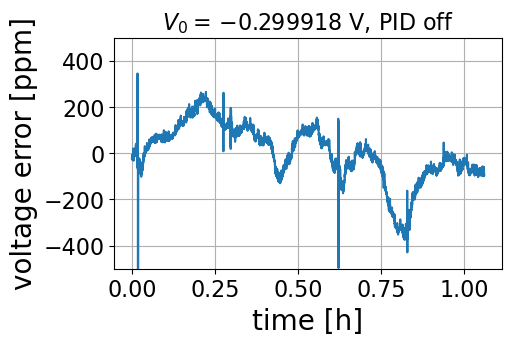

In [538]:
voltage_plot(
    rn_arr   = [f"X-{i}" for i in range(9999)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID off",
    V0      = "avg",
    ylim    = [-500, 500],
#     win_fn  = windows.hann,
    win_len = 50,
    leg_loc = (1.05, .2),
)

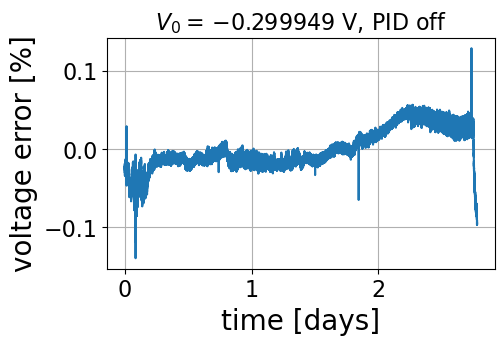

In [552]:
voltage_plot(
    rn_arr   = [f"Y-{i}" for i in range(9999)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID off",
    V0      = "avg",
    rel_unit = "%",
#     ylim    = [-1000, 1000],
#     win_fn  = windows.hann,
    win_len = 50,
    leg_loc = (1.05, .2),
)

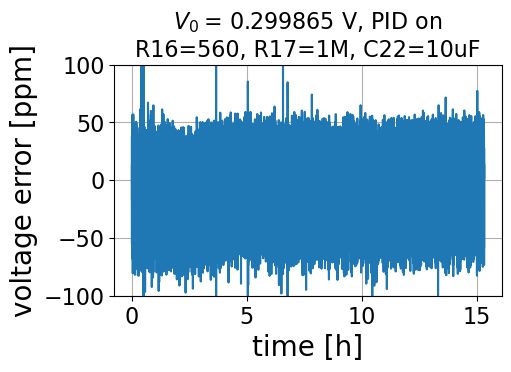

In [586]:
voltage_plot(
    rn_arr   = [f"a-{i}" for i in range(9999)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID on\nR16=560, R17=1M, C22=10uF",
    V0      = "avg",
    rel_unit = "ppm",
    ylim    = [-100, 100],
#     win_fn  = windows.hann,
    win_len = 50,
    leg_loc = (1.05, .2),
)

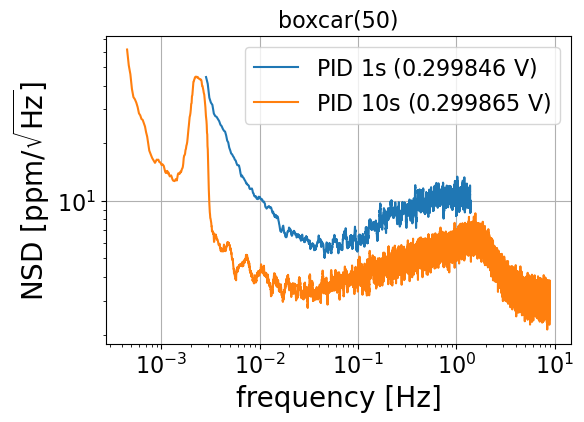

In [606]:
plot_spectra(
    rn_arr_arr = [
                    [f"W-{i}" for i in range(9999)],
                    [f"a-{i}" for i in range(9999)],
                 ],
    fname    = "HV_leakage_test.hdf",
    lab_arr    = ["PID 1s", "PID 10s"],
    V0_arr     = [None, None, None, None, None, None],
    figsize = (6,4),
    win_fn  = windows.boxcar,
    win_len = 50,
    leg_loc = "upper right",
#     ylim       = (1e-2, 1e3),
#     hline      = 0.05,
#     vline      = 1e-2,
)

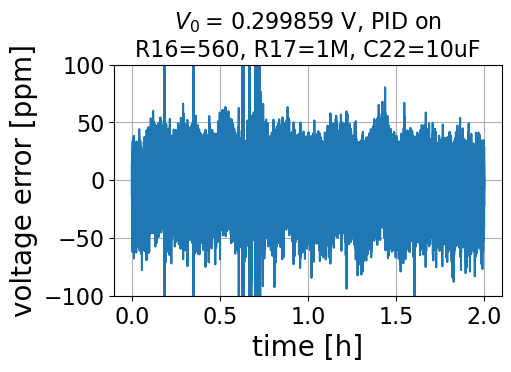

In [601]:
voltage_plot(
    rn_arr   = [f"b-{i}" for i in range(999)],
    fname    = "HV_leakage_test.hdf",
    figsize = (5,3),
    comment = ", PID on\nR16=560, R17=1M, C22=10uF",
    V0      = "avg",
    rel_unit = "ppm",
    ylim    = [-100, 100],
#     win_fn  = windows.hann,
    win_len = 50,
    leg_loc = (1.05, .2),
)

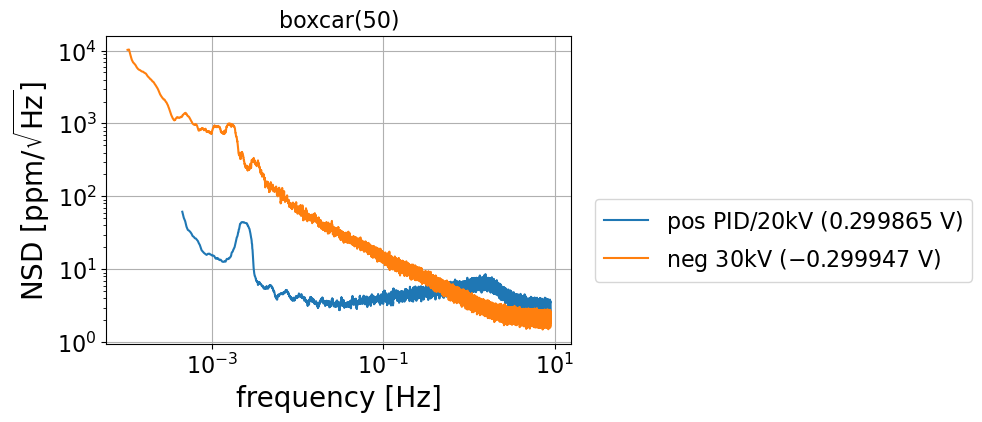

In [604]:
plot_spectra(
    rn_arr_arr = [
                    [f"a-{i}" for i in range(9999)],
                    [f"Y-{i}" for i in range(9999)],
                 ],
    fname    = "HV_leakage_test.hdf",
    lab_arr    = ["pos PID/20kV", "neg 30kV"],
    V0_arr     = [None, None, None, None, None, None],
    figsize = (6,4),
    win_fn  = windows.boxcar,
    win_len = 50,
    leg_loc = (1.05, .2),
#     ylim       = (1e-2, 1e3),
#     hline      = 0.05,
#     vline      = 1e-2,
)